# Predicting multiple Indian stocks using a single LSTM model
### Our goal prediect two stocks model for each and then combaind the data in one dataset then try to predict the whole dataset 

### Importing libraries

In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dropout, Dense
import sklearn
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

### Defining the mean absolute percent error metric and mean squared percent error metric

In [80]:
def mean_absolute_percent_error(y_true,y_pred):
    total = np.sum(np.divide(np.array(y_pred),np.array(y_true)))
    return 100*np.abs((len(y_true))-total)/len(y_true)

In [225]:
def mean_squared_percent_error(y_true,y_pred):
    total = np.sum(np.divide(np.array(y_pred),np.array(y_true)))
    return 100*  ((((len(y_true))-total)/len(y_true))**2)

### Importing the stock data

##### We will just use the closing price to predict and forecast the same 

In [81]:
stock_list = ["GAIL", "RELIANCE",]
df = {}
for stock in stock_list:
    df[stock] = pd.read_csv(r"./DataSets/" + stock + ".csv", index_col="Date", parse_dates=["Date"])
    df[stock] = df[stock]["Close"]

In [239]:
# this function will take the object varable and concat all the dataset in one data frame then return it 
def mearge_all_data (data):
   columns = list(data.keys())
   print(columns)
   temp_df = data[columns[0]]
   for i, col in  enumerate(columns):
      if(i == 0):
         continue
   
      temp_df =  pd.concat([temp_df,data[col]])

   return temp_df
      

here we want to create dataset to mearge the all stocks and call it "all"

In [83]:
all_df= mearge_all_data(df)
stock_list.append('all')
df['all'] = all_df

['GAIL', 'RELIANCE']


In [84]:
stock_list

['GAIL', 'RELIANCE', 'all']

### Exploaring the data

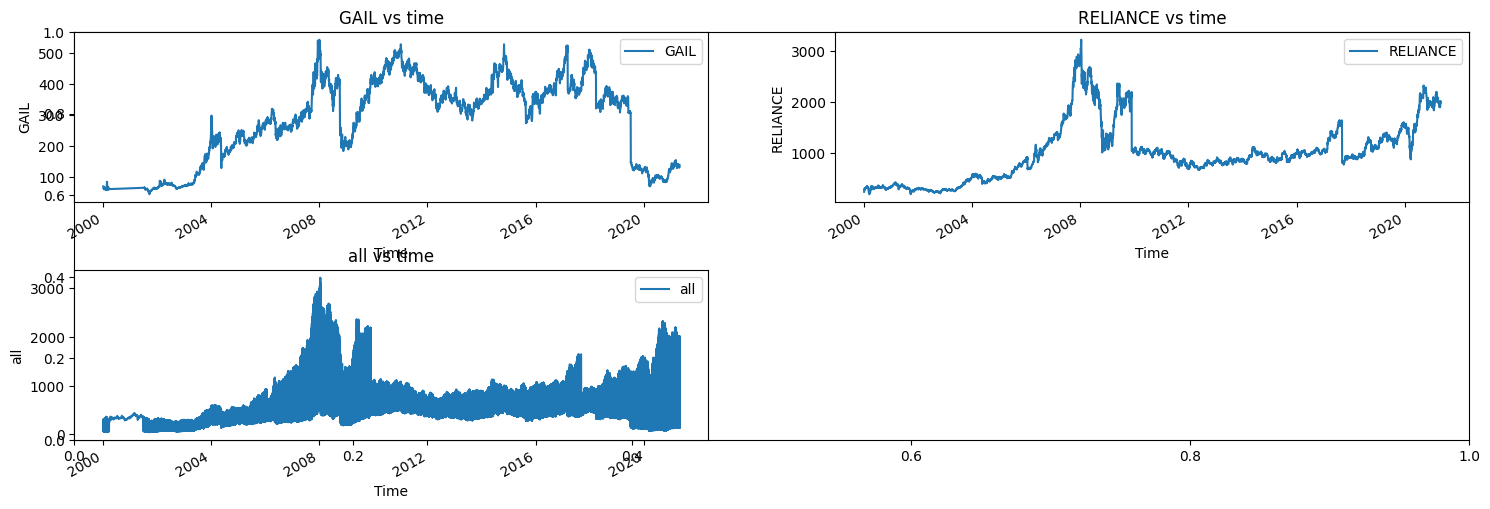

In [89]:
fig, ax = plt.subplots(1,1, figsize=(18,6))
i=1
for stock in stock_list:
    plt.subplot(2,2,i)
    df[stock].plot(label=stock)
    plt.xlabel('Time')
    plt.ylabel(stock)
    plt.title(stock+' vs time')
    plt.legend()
    i = i+1
plt.subplots_adjust(hspace=0.4)

### Measuring the daily returns of the stocks

#### We will measure the daily change in the stock price and check what distribution it follows

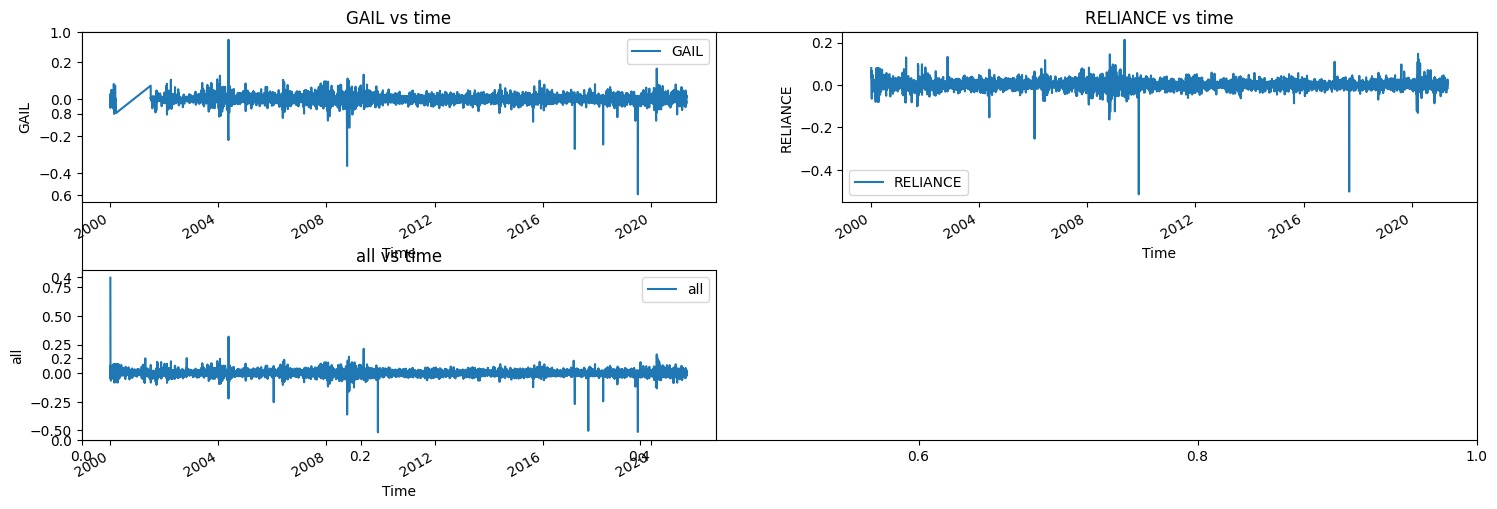

In [90]:
fig, ax = plt.subplots(1,1, figsize=(18,6))
i=1
for stock in stock_list:
    plt.subplot(2,2,i)
    temp = df[stock].pct_change()
    temp.plot(label=stock)
    plt.xlabel('Time')
    plt.ylabel(stock)
    plt.title(stock+' vs time')
    plt.legend()
    i = i+1
plt.subplots_adjust(hspace=0.4)

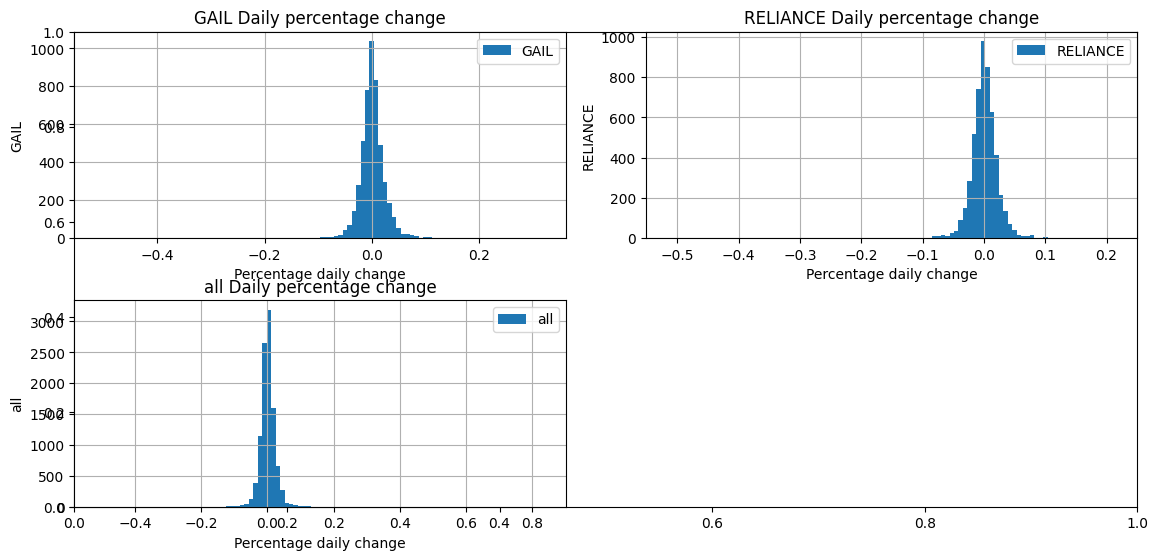

In [92]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
i=1
for stock in stock_list:
    plt.subplot(2,2,i)
    temp = df[stock].pct_change()
    temp.hist(label=stock, bins = 100)
    plt.xlabel('Percentage daily change')
    plt.ylabel(stock)
    plt.title(stock+' Daily percentage change')
    plt.tight_layout()
    plt.legend()
    i = i+1
plt.subplots_adjust(hspace=0.3)

### Splitting the data for training and testing two 60,20 and 20 for validation



In [94]:
# startdate = dt.datetime.strptime('2018-01-01', "%Y-%m-%d").date()

training_df = {}
testing_df = {}
for stock, data in df.items():
    training_df[stock] = data.loc[data.index < '2018-01-01']
    testing_df[stock]  = data.loc[data.index >= '2018-01-01']
    


In [ ]:
n = len(all_df)
split_point1 = int(n * 0.8)  # 60% for training
split_point2 = int(n * 0.9)  # Next 20% for validation
print(split_point1)
train = all_df.iloc[:split_point1]

test = all_df.iloc[split_point1:]
training_df['all'] =  train
testing_df['all'] = test
train.head()

8232


Date
2000-01-03    68.70
2000-01-04    66.35
2000-01-05    63.20
2000-01-06    64.95
2000-01-07    62.65
Name: Close, dtype: float64

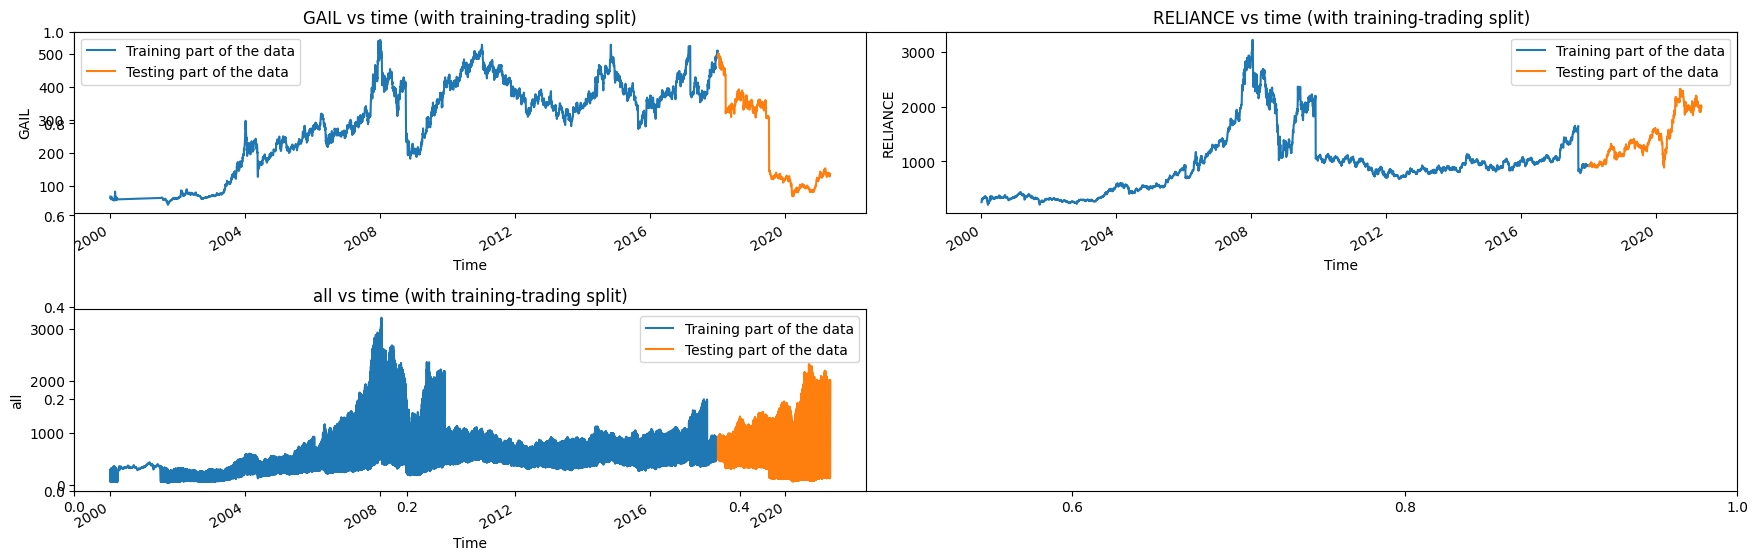

In [238]:
fig, ax = plt.subplots(figsize=(18,6))
i=1
for stock in stock_list:
    plt.subplot(2,2,i)
    training_df[stock].plot(label="Training part of the data")
    testing_df[stock].plot(label="Testing part of the data")
    # plt.axvline('2018-01-01', color='black', ls='--')
    plt.xlabel('Time')
    plt.ylabel(stock)
    plt.legend()
    plt.title(stock +' vs time (with training-trading split)')
    i=i+1

plt.tight_layout()
plt.show()



### Scaling the data 

#### Neural networks are sensitive to the scale of input features. Large differences in feature scales can lead to instability in training, resulting in vanishing or exploding gradients. Scaling mitigates this issue, making the training process more stable.

In [97]:
scalers = {}
train_set = {}
test_set = {}

for stock in stock_list:
    scaler = MinMaxScaler()
    scaler.fit(df[stock].values.reshape(-1, 1))
    train_set[stock] = scaler.transform(training_df[stock].values.reshape(-1, 1))
    test_set[stock] = scaler.transform(testing_df[stock].values.reshape(-1, 1))
    scalers[stock] = scaler

#### Preparing the Data for the LSTM Model

We will use a context window of 12 days for modeling. The idea is that the model will be given 12 days of time series data to predict the value of the next day, which is day 13.

Here, we aim to return arrays `X` and `Y`, where `X` contains 12 days of time series data, and `Y` contains the data for day 13. 

**Example:** 
- `X`: `[[1, 2, 3], [2, 3, 4]]`
- `Y`: `[4, 5]`


In [311]:
# function to create a timseries data the x is the data to train  and the y is the data to test which here will be the target  
def create_series(data_array):
    LEN_DATA = len(data_array)
    seql_length = 12
    X, Y = [], []

    for i in range(LEN_DATA - seql_length):
        x, y = data_array[i:seql_length + i], data_array[seql_length + i]
        x, y = np.array(x), np.array(y)
        X.append(x); Y.append(y)

    return np.array(X), np.array(Y)

In [312]:
data_train = {}
data_test = {}

for stock in stock_list:
    X_train, Y_train = create_series(train_set[stock])
    X_test, Y_test = create_series(test_set[stock])
    
    data_train[stock] = [X_train, Y_train]
    data_test[stock] = [X_test, Y_test]
    print(f'{stock} shape before :{train_set[stock].shape}, shape after :X{X_train.shape}, Y{Y_train.shape}')

GAIL shape before :(4162, 1), shape after :X(4150, 12, 1), Y(4150, 1)
RELIANCE shape before :(4483, 1), shape after :X(4471, 12, 1), Y(4471, 1)
all shape before :(8645, 1), shape after :X(8633, 12, 1), Y(8633, 1)


### Creating and training the model

In [211]:
from sklearn.model_selection import KFold


#  'stock_list' contains the list of stocks you're training on
# and 'data_train' is structured as {stock: (features, labels)}

n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=False)

# Preparing to collect histories
histories = {stock: [] for stock in stock_list}
for stock in stock_list:
    print("Training on " + stock)
    X = np.array(data_train[stock][0])  # Convert features to NumPy array for compatibility with KFold
    y = np.array(data_train[stock][1])  # Convert labels to NumPy array
    
    # Initialize K-fold cross-validation
    fold = 0
    for train_index, val_index in kf.split(X):
        fold += 1
        print(f"Fold {fold} for {stock}")
        
        # Splitting the data into training and validation sets for the current fold
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Defining the model inside the loop to reset it for each fold
        model = tf.keras.Sequential([
        LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
                  ])
        
        
        model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                      loss=tf.keras.losses.MeanSquaredError(),
                      metrics=['mae'])  # Assuming accuracy is relevant for your problem
        
        # Train the model on the current fold
        history = model.fit(X_train, y_train, epochs=8, batch_size=16, validation_data=(X_val, y_val), verbose=True)
        
        # Save the history for each fold
        histories[stock].append(history)
        



Training on GAIL
Fold 1 for GAIL
Epoch 1/8
208/208 [==============================] - 2s 4ms/step - loss: 0.0166 - mae: 0.0626 - val_loss: 0.0069 - val_mae: 0.0772
Epoch 2/8
208/208 [==============================] - 1s 3ms/step - loss: 0.0019 - mae: 0.0334 - val_loss: 0.0052 - val_mae: 0.0686
Epoch 3/8
208/208 [==============================] - 1s 3ms/step - loss: 0.0016 - mae: 0.0296 - val_loss: 0.0025 - val_mae: 0.0461
Epoch 4/8
208/208 [==============================] - 1s 4ms/step - loss: 0.0014 - mae: 0.0282 - val_loss: 0.0012 - val_mae: 0.0318
Epoch 5/8
208/208 [==============================] - 1s 3ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0014 - val_mae: 0.0344
Epoch 6/8
208/208 [==============================] - 1s 3ms/step - loss: 0.0011 - mae: 0.0251 - val_loss: 3.0591e-04 - val_mae: 0.0121
Epoch 7/8
208/208 [==============================] - 1s 4ms/step - loss: 9.9998e-04 - mae: 0.0233 - val_loss: 3.9348e-04 - val_mae: 0.0163
Epoch 8/8
208/208 [===================

In [210]:
model.summary()

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_140 (LSTM)             (None, 100)               40800     
                                                                 
 dense_95 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
average_histories = {}

for stock in stock_list:
    # Initialize a dictionary to sum the losses across folds
    avg_history = {'loss': [], 'val_loss': []}
    
    # Calculate the total number of epochs from the first fold (assuming all folds have the same number of epochs)
    n_epochs = len(histories[stock][0].history['loss'])
    
    for epoch in range(n_epochs):
        # Initialize sums for each epoch
        sum_loss = 0
        sum_val_loss = 0
        
        # Sum losses across all folds for the current epoch
        for fold_history in histories[stock]:
            sum_loss += fold_history.history['loss'][epoch]
            sum_val_loss += fold_history.history['val_loss'][epoch]
        
        # Calculate average loss for the current epoch
        avg_history['loss'].append(sum_loss / len(histories[stock]))
        avg_history['val_loss'].append(sum_val_loss / len(histories[stock]))
    
    # Store the average history for the current stock
    average_histories[stock] = avg_history


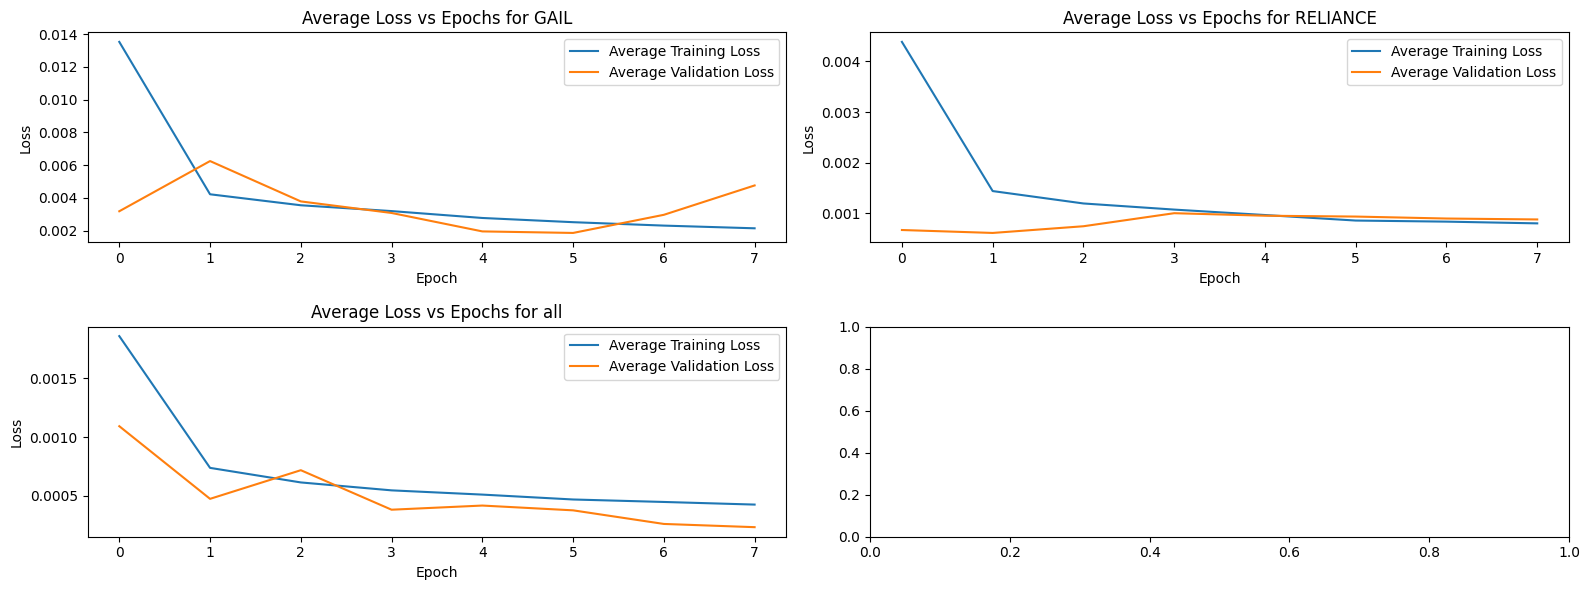

In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(16, 6))  # Adjust the subplot structure to match your number of stocks

for i, stock in enumerate(stock_list):
    ax = axs[i // 2, i % 2]  # This assumes you have a 2x2 grid. Adjust accordingly if you have more stocks.
    epochs = range(len(average_histories[stock]['loss']))
    ax.plot(epochs, average_histories[stock]['loss'], label='Average Training Loss')
    ax.plot(epochs, average_histories[stock]['val_loss'], label='Average Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Average Loss vs Epochs for ' + stock)
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


In [ ]:

train_losses = np.array([])
val_losses = np.array([])

for stock in stock_list:
    for fold_history in histories[stock]:
        # Extract the losses for the current fold
        current_train_losses = np.array(fold_history.history['loss'])
        current_val_losses = np.array(fold_history.history['val_loss'])
        
        # Concatenate the current fold's losses with the total losses
        train_losses = np.concatenate([train_losses, current_train_losses])
        val_losses = np.concatenate([val_losses, current_val_losses])


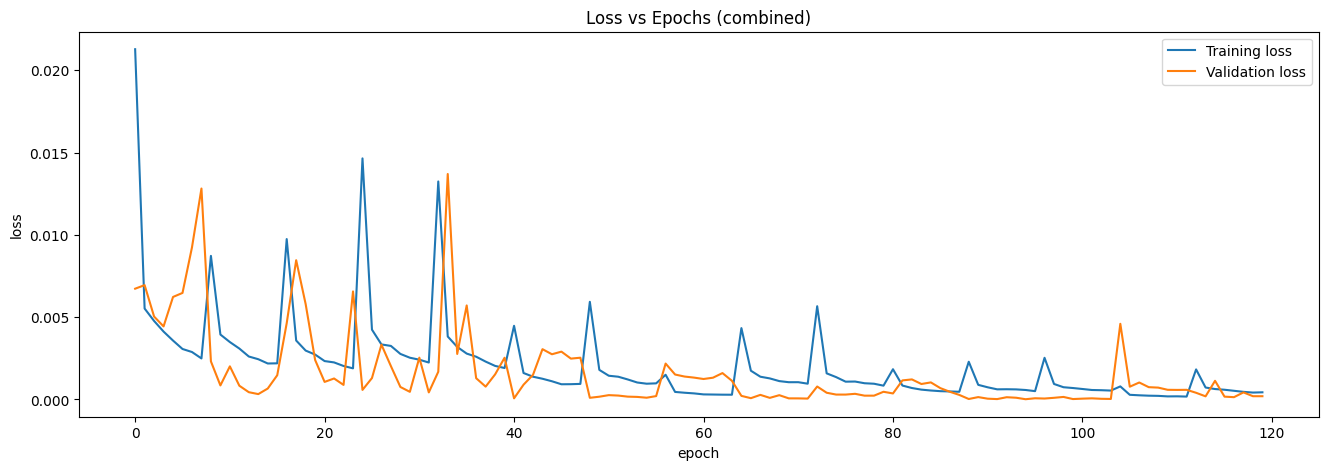

loss 


In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(train_losses, label = 'Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epochs (combined)')
plt.legend()
plt.show()

print('loss ')

In [ ]:
predictions = {}
for stock in stock_list:
    print("Predicting on " + stock)
    predictions[stock] = model.predict(data_test[stock][0])

Predicting on GAIL
26/26 [==============================] - 0s 2ms/step
Predicting on RELIANCE
26/26 [==============================] - 0s 2ms/step
Predicting on all
52/52 [==============================] - 0s 2ms/step


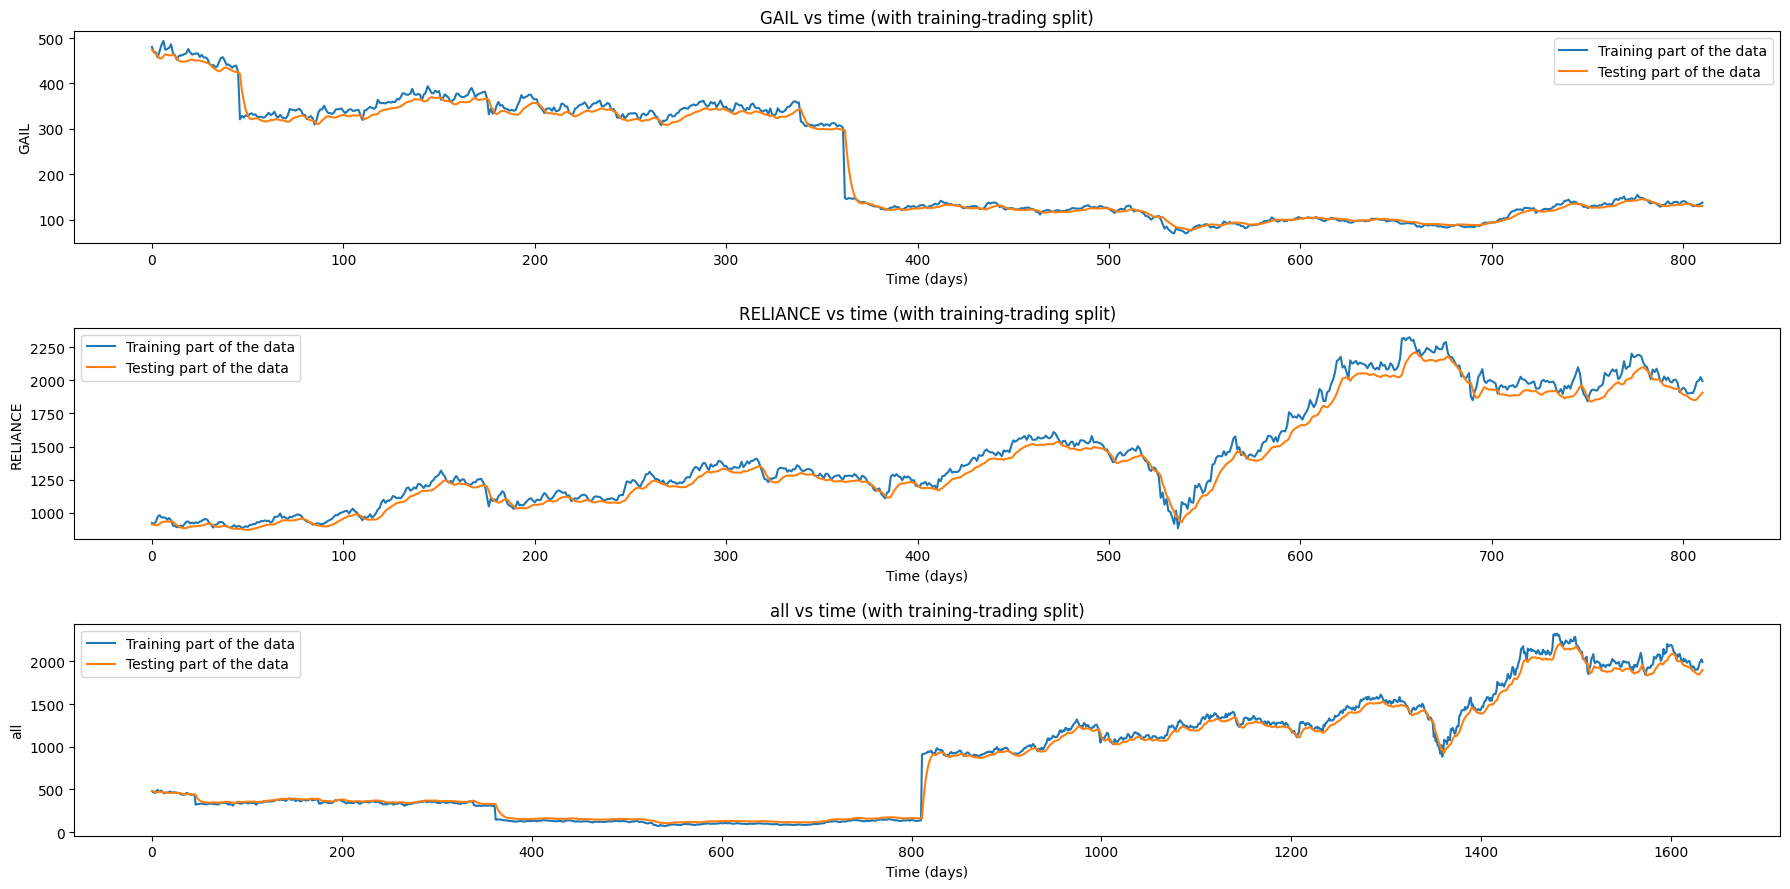

In [ ]:
fig, axs = plt.subplots(len(stock_list), 1, figsize=(18, 9)) # Adjust subplot creation to match the number of stocks

for i, stock in enumerate(stock_list):
    # Check if there's only one subplot (in case stock_list has only one item)
    if len(stock_list) == 1:
        ax = axs
    else:
        ax = axs[i]
    
    # Plotting on the appropriate subplot
    ax.plot(scalers[stock].inverse_transform(data_test[stock][1]), label="Training part of the data")
    ax.plot(scalers[stock].inverse_transform(predictions[stock]), label="Testing part of the data")
    ax.set_xlabel('Time (days)')
    ax.set_ylabel(stock)
    ax.legend()
    ax.set_title(stock + ' vs time (with training-trading split)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4) # Adjust spacing to ensure labels and titles don't overlap
plt.show()


In [230]:
for stock in stock_list:
     print(stock)
     print(f'mean absolute error : {mean_absolute_percent_error(data_test[stock][1],predictions[stock]).round(2)}%')
     print(f'mean squared error: {mean_squared_percent_error(data_test[stock][1],predictions[stock]).round(2)}% ')
     

GAIL
mean absolute error : 0.82%
mean squared error: 0.01% 
RELIANCE
mean absolute error : 3.8%
mean squared error: 0.14% 
all
mean absolute error : 11.33%
mean squared error: 1.28% 
